Q3 Modularity

In [25]:
import networkx as nx
import community as community_louvain
import pandas as pd

# Load graph
graphml_path = r'B:\Final Network Science Project\Data\grpah file\Shipping_Network.graphml'
G = nx.read_graphml(graphml_path)

# Louvain community detection
partition = community_louvain.best_partition(G, weight='weight')

# Group nodes by community
from collections import defaultdict

community_dict = defaultdict(list)
for node, comm_id in partition.items():
    community_dict[comm_id].append(node)

# Log total number of communities
print(f"Total communities detected: {len(community_dict)}")
print("Communities and their sizes:")
for k, v in community_dict.items():
    print(f"Community {k}: {len(v)} nodes")

# Pad communities to the same length
max_len = max(len(nodes) for nodes in community_dict.values())
for k in community_dict:
    community_dict[k] += [None] * (max_len - len(community_dict[k]))

# Convert to DataFrame with each community as a column
community_df = pd.DataFrame({
    f"Community {k}": v for k, v in sorted(community_dict.items())
})

# Save to CSV
community_df.to_csv("louvain_communities_all.csv", index=False)
print("Saved complete community listing to 'louvain_communities_all.csv'")


Total communities detected: 3
Communities and their sizes:
Community 2: 455 nodes
Community 1: 329 nodes
Community 0: 124 nodes
Saved complete community listing to 'louvain_communities_all.csv'


In [26]:
# Compute modularity score
modularity_score = community_louvain.modularity(partition, G, weight='weight')
print(f"Modularity Score: {modularity_score:.4f}")

# Interpretation
if modularity_score > 0.4:
    print("The network has a strong community structure.")
elif modularity_score > 0.3:
    print("The network has a moderately strong community structure.")
else:
    print("The network has a weak community structure.")


Modularity Score: 0.1507
The network has a weak community structure.


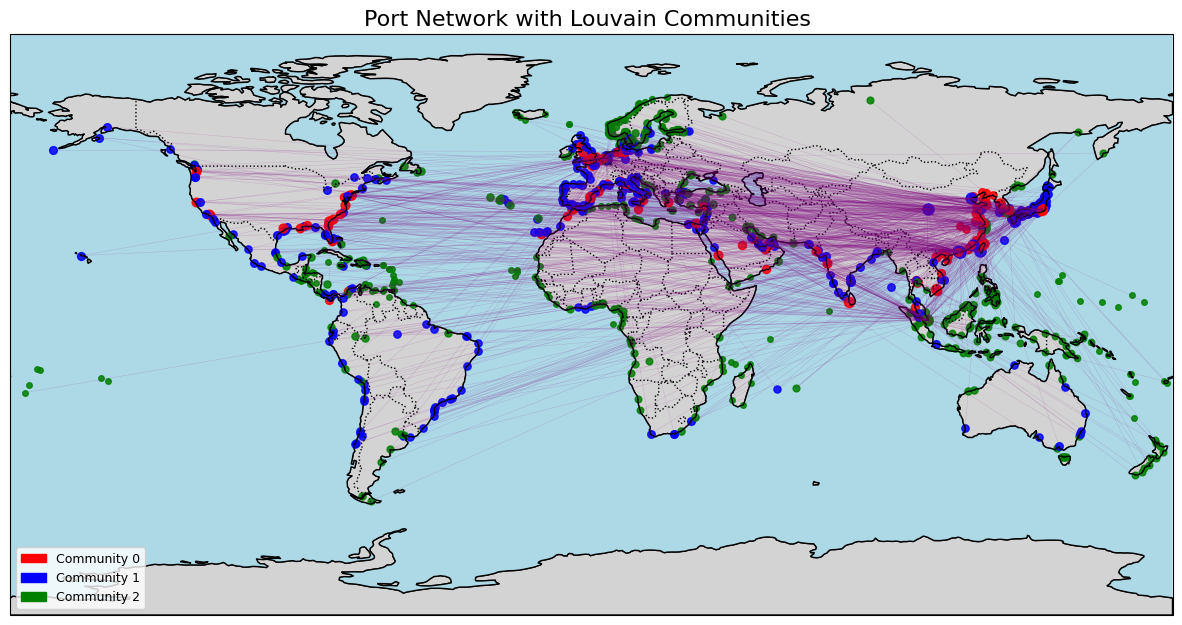

In [39]:
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

# Load the graph
graphml_file = r"B:\Final Network Science Project\Data\grpah file\Shipping_Network.graphml"
G = nx.read_graphml(graphml_file)

# Load community CSV file
community_csv = r"B:\Final Network Science Project\louvain_communities_all.csv"
df = pd.read_csv(community_csv)

# Create node-to-community mapping
node_to_community = {}
for col in df.columns:
    for node in df[col].dropna():
        node_to_community[node] = int(col.split()[-1]) if "Community" in col else int(col)

# Define custom colors: light blue, orange, green
custom_colors = ['Red', 'Blue', 'Green']  # Light blue, orange, green
communities = sorted(set(node_to_community.values()))
community_colors = {comm: custom_colors[i % len(custom_colors)] for i, comm in enumerate(communities)}

# Prepare node positions and degrees
node_positions = {}
node_degrees = {}


for node, data in G.nodes(data=True):
    lat = data.get('latitude')
    lon = data.get('longitude')
    if lat and lon:
        node_positions[node] = (float(lon), float(lat))
    node_degrees[node] = G.degree(node)

# Filter edges to reduce clutter
filtered_edges = [edge for edge in G.edges() if np.random.rand() < 0.1]

# Plotting
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot nodes with log-scaled sizes
for node, (lon, lat) in node_positions.items():
    degree = node_degrees.get(node, 1)
    size = np.log1p(degree) * 10  # log scale
    comm_id = node_to_community.get(node)
    color = community_colors.get(comm_id, (0.5, 0.5, 0.5))
    ax.scatter(
        lon, lat,
        s=size,
        color=color,
        alpha=0.85,
        transform=ccrs.PlateCarree()
    )

# Plot edges
for source, target in filtered_edges:
    if source in node_positions and target in node_positions:
        lon1, lat1 = node_positions[source]
        lon2, lat2 = node_positions[target]
        ax.plot(
            [lon1, lon2], [lat1, lat2],
            color='purple',
            linewidth=0.3,
            alpha=0.2,
            transform=ccrs.PlateCarree()
        )

# Title and legend
plt.title("Port Network with Louvain Communities ", fontsize=16)
legend_patches = [mpatches.Patch(color=community_colors[comm], label=f"Community {comm}") for comm in communities]
plt.legend(handles=legend_patches, loc="lower left", fontsize=9)

plt.show()
